In [46]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_excel("cust_dataa.xlsx")
df.head()

,InvoiceNo,StockCode,Department Name,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,Intimate,6,2017-12-01 08:26:00,2.55,17850.0,United States
1,536365,71053,Dresses,6,2017-12-01 08:26:00,3.39,17850.0,United States
2,536365,84406B,Dresses,8,2017-12-01 08:26:00,2.75,17850.0,United States
3,536365,84029G,Bottoms,6,2017-12-01 08:26:00,3.39,17850.0,United States
4,536365,84029E,Tops,6,2017-12-01 08:26:00,3.39,17850.0,United States


In [47]:
import seaborn as sns
sns.set_palette("husl")
sns.set(rc={'image.cmap': 'coolwarm'})
%matplotlib inline

In [48]:
import datetime as dt
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date

In [49]:

df = df[pd.notnull(df['CustomerID'])]
df = df[(df['Quantity']>0)]

In [50]:
df['Sales'] = df['Quantity'] * df['UnitPrice']
cols_of_interest = ['CustomerID', 'InvoiceDate', 'Sales']
df = df[cols_of_interest]

In [51]:

print(df.head())
print(df['CustomerID'].nunique())

   CustomerID InvoiceDate  Sales
0     17850.0  2017-12-01  15.30
1     17850.0  2017-12-01  20.34
2     17850.0  2017-12-01  22.00
3     17850.0  2017-12-01  20.34
4     17850.0  2017-12-01  20.34
4339


In [56]:
from lifetimes.plotting import *
from lifetimes.utils import *
#from lifetimes.estimation import *
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value

data = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col='Sales', observation_period_end='2018-12-9')
data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
0.3569946992394561


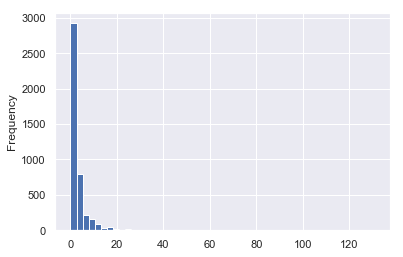

In [57]:

data['frequency'].plot(kind='hist', bins=50)
print(data['frequency'].describe())
print(sum(data['frequency'] == 0)/float(len(data)))

In [58]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


In [59]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


In [60]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14606.0,88.0,372.0,373.0,135.890114,0.201005
15311.0,89.0,373.0,373.0,677.729438,0.203269
17841.0,111.0,372.0,373.0,364.452162,0.253053
12748.0,113.0,373.0,373.0,298.360885,0.257581
14911.0,131.0,372.0,373.0,1093.661679,0.298312


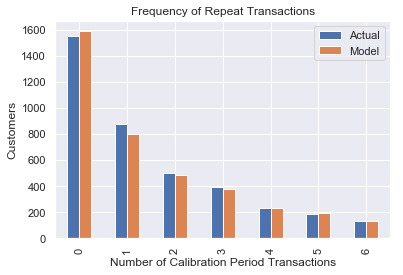

In [61]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [64]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2018-06-08',
                                        observation_period_end='2018-12-9' )   
print(summary_cal_holdout.head())

            frequency_cal  recency_cal  T_cal  frequency_holdout  \
CustomerID                                                         
12346.0               0.0          0.0  141.0                0.0   
12347.0               2.0        121.0  183.0                4.0   
12348.0               2.0        110.0  174.0                1.0   
12350.0               0.0          0.0  126.0                0.0   
12352.0               3.0         34.0  112.0                3.0   

            duration_holdout  
CustomerID                    
12346.0                  184  
12347.0                  184  
12348.0                  184  
12350.0                  184  
12352.0                  184  


In [66]:

returning_customers_summary = data[data['frequency']>0]

print(returning_customers_summary.head())
print(len(returning_customers_summary))

            frequency  recency      T  monetary_value  predicted_purchases
CustomerID                                                                
12347.0           6.0    365.0  367.0      599.701667             0.015656
12348.0           3.0    283.0  358.0      301.480000             0.008956
12352.0           6.0    260.0  296.0      368.256667             0.018697
12356.0           2.0    303.0  325.0      269.905000             0.007172
12358.0           1.0    149.0  150.0      683.200000             0.008340
2790


In [67]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.015882
frequency,0.015882,1.000000


In [68]:
df.to_csv('Customer Lifetime value.csv')